# Sync

In [18]:
!aws s3 sync resources/grn-benchmark s3://openproblems-data/resources/grn/grn-benchmark --delete
!aws s3 sync resources/grn_models/ s3://openproblems-data/resources/grn/grn_models --delete
!aws s3 sync resources/prior/ s3://openproblems-data/resources/grn/prior --delete
!aws s3 sync resources/supplementary/ s3://openproblems-data/resources/grn/supplementary --delete
# !aws s3 sync resources/results/ s3://openproblems-data/resources/grn/results --delete

upload: resources/grn_models/d0_hvg/collectri.csv to s3://openproblems-data/resources/grn/grn_models/d0_hvg/collectri.csv
upload: resources/grn_models/d0_hvg/scglue.csv to s3://openproblems-data/resources/grn/grn_models/d0_hvg/scglue.csv
upload: resources/grn_models/d0_hvg/celloracle.csv to s3://openproblems-data/resources/grn/grn_models/d0_hvg/celloracle.csv
delete: s3://openproblems-data/resources/grn/grn_models/d0_hvgs/celloracle.csv
delete: s3://openproblems-data/resources/grn/grn_models/d0_hvgs/collectri.csv
delete: s3://openproblems-data/resources/grn/grn_models/d0_hvgs/genie3.csv
delete: s3://openproblems-data/resources/grn/grn_models/d0_hvgs/grnboost2.csv
delete: s3://openproblems-data/resources/grn/grn_models/d0_hvgs/negative_control.csv
delete: s3://openproblems-data/resources/grn/grn_models/d0_hvgs/pearson_causal.csv
delete: s3://openproblems-data/resources/grn/grn_models/d0_hvgs/pearson_corr.csv
upload: resources/grn_models/d0_hvg/ppcor.csv to s3://openproblems-data/resourc

# Import

In [1]:
import yaml
import pandas as pd
import anndata as ad 
import numpy as np
import scanpy as sc 
from src.exp_analysis.helper import plot_cumulative_density
import sys 
import subprocess
import io
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('../')
from grn_benchmark.src.commons import surragate_names
def extract_data(data, reg='reg1', dataset_id='scgen_pearson'):
    i = 0
    for entry in data:
        if entry['dataset_id']!=dataset_id:
            continue
        try:
            rg, method_id = entry['method_id'].split('-')
        except:
            rg, method_id, _ = entry['method_id'].split('-')
        if rg != reg:
            continue
        dataset_id = entry['dataset_id']
        metric_ids = entry['metric_ids']
        metric_values = entry['metric_values']
        
        df = pd.DataFrame([metric_values], index=[method_id], columns=metric_ids)
        if i==0:
            df_reg = df
        else:
            df_reg = pd.concat([df_reg, df], axis=0)
        i+=1
    return df_reg
def process_data(RUN_ID, models_all=None):
    !aws s3 sync s3://openproblems-data/resources/grn/results/{RUN_ID} resources/results/{RUN_ID} 
    base_folder = f'resources/results/{RUN_ID}'
    result_file = f'{base_folder}/scores.yaml'
        

    with open(result_file, 'r') as file:
        data = yaml.safe_load(file)
    
    
    if models_all is None:
        df_reg1 = extract_data(data, reg='reg1')
        df_reg2 = extract_data(data, reg='reg2')
    else:
        df_reg1 = extract_data(data, reg='reg1').reindex(models_all)
        df_reg2 = extract_data(data, reg='reg2').reindex(models_all)
    # df_all = pd.concat([df_reg1, df_reg2], axis=1).fillna(0)
    # df_all_n = (df_all-df_all.min(axis=0))/(df_all.max(axis=0)-df_all.min(axis=0))
    # df_all['Rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
    df_all = pd.concat([df_reg1, df_reg2], axis=1)
    return df_all
def process_trace_seqera(trace):
    trace['model'] = pd.DataFrame(trace.name.str.split(':').to_list())[3] #TODO: number 3 might be different  
    trace = trace.groupby('model').apply(lambda df: df.sort_values(by='duration', ascending=False).iloc[0])[['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar', 'duration']]

    def convert_duration_to_hours(duration_str):
        import re
        hours, minutes, seconds = 0, 0, 0
        time_parts = re.findall(r'(\d+)([hms])', duration_str)
        for value, unit in time_parts:
            if unit == 'h':
                hours = int(value)
            elif unit == 'm':
                minutes = int(value)
            elif unit == 's':
                seconds = int(value)
        return (hours * 3600 + minutes * 60 + seconds)/3600
    def format_ram(row):
        value = float(row.split()[0])
        if 'GB' in row:
            value = value
        elif 'MB' in row:
            value = value/1000
        else:
            raise ValueError('Define')
        return value 

    for col in trace.columns:
        if col=='%cpu':
            trace[col] = trace[col].str.replace('%', '').astype(float)
        elif col=='duration':
            trace[col] = trace[col].apply(convert_duration_to_hours)
        else:
            trace[col] = trace[col].apply(format_ram)
    return trace 
def process_trace_local(job_ids_dict):
    def get_sacct_data(job_id):
        command = f'sacct -j {job_id} --format=JobID,JobName,AllocCPUS,Elapsed,State,MaxRSS,MaxVMSize'
        output = subprocess.check_output(command, shell=True).decode()
        
        # Load the output into a DataFrame
        df = pd.read_csv(io.StringIO(output), delim_whitespace=True)
        df = df.iloc[[2]]
        return df
    def elapsed_to_hours(elapsed_str):
        time = elapsed_str.split('-')
        if len(time) > 1:
            day = int(time[0])
            time = time[1]
        else:
            day = 0
            time = time[0]
        h, m, s = map(int, time.split(':'))
        return day*24 + h + m / 60 + s / 3600
    for i, (name, job_id) in enumerate(job_ids_dict.items()):
        df = get_sacct_data(job_id)
        df.index = [name]
        if i==0:
            df_local = df
        else:
            df_local = pd.concat([df_local, df], axis=0)
        
    # Remove 'K' and convert to integers
    df_local['MaxRSS'] = df_local['MaxRSS'].str.replace('K', '').astype(int)
    df_local['MaxVMSize'] = df_local['MaxVMSize'].str.replace('K', '').astype(int)
    df_local['Elapsed'] = df_local['Elapsed'].apply(lambda x: (elapsed_to_hours(x)))

    # Convert MaxRSS and MaxVMSize from KB to GB
    df_local['MaxRSS'] = df_local['MaxRSS'] / (1024 ** 2)  # Convert KB to GB
    df_local['MaxVMSize'] = df_local['MaxVMSize'] / (1024 ** 2)  # Convert KB to GB
    return df_local
par = {
    # 'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'genie3', 'grnboost2', 'scenic', 'scglue', 'celloracle'],
    'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'grnboost2', 'scenic', 'scglue', 'celloracle'],
    'models_dir': 'resources/grn_models/',
    'scores_dir': 'resources/scores',
    'multiomics_rna': 'resources/grn-benchmark/multiomics_rna.h5ad', 
    'multiomics_atac': 'resources/grn-benchmark/multiomics_atac.h5ad', 
    'num_workers': 20,
    'mem': "100G",
    'time': "24:00:00"
}



# Marco data 

In [3]:
# import subprocess
# import anndata as ad 
# import pandas as pd
# import numpy as np
# for cell_type in ['zhao', 'shalek', 'han', 'jackson']:
#     adata = ad.read_h5ad(f'resources_local/mccalla_extended/{cell_type}.h5ad')
#     adata.layers['norm'] = adata.X
#     adata.obs['cell_type'] = 'onecelltype'
#     adata.write(f'resources_local/mccalla_extended/{cell_type}.h5ad')
#     subsample = min([10000, len(adata)])
#     for GT in ['KDunion', 'chipunion', 'chipunion_KDUnion_intersect']:
#         GT_df = pd.read_csv(f'resources_local/mccalla_extended/{cell_type}_{GT}.csv')
#         gene_overlap = np.intersect1d(adata.var_names, GT_df.target.unique()).shape
#         print(f"{cell_type}-{GT}. adata shape: {adata.shape}, GT size: {GT_df.shape}, Gene overlap: {gene_overlap}")
#         command = f"viash run src/metrics/regression_1/config.vsh.yaml -- --perturbation_data resources_local/mccalla_extended/{cell_type}.h5ad --prediction resources_local/mccalla_extended/{cell_type}_{GT}.csv --layer norm --subsample {subsample} --apply_tf false --tf_all resources/prior/tf_all.csv --max_n_links -1 --verbose 1 --score output/{cell_type}_{GT}.h5ad"
#         subprocess.run(command, shell=True, check=True)

# Run grn inference 

### scGLUE evaluations

In [2]:
# pd.read_feather('output/scglue/supp.genes_vs_tracks.rankings.feather')
rna = ad.read_h5ad(f"output/scglue/rna-emb.h5ad")
atac= ad.read_h5ad(f"output/scglue/atac-emb.h5ad")

In [12]:
rna.varm['X_glue'].shape

(17075, 50)

In [6]:
combined = ad.concat([rna, atac])
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


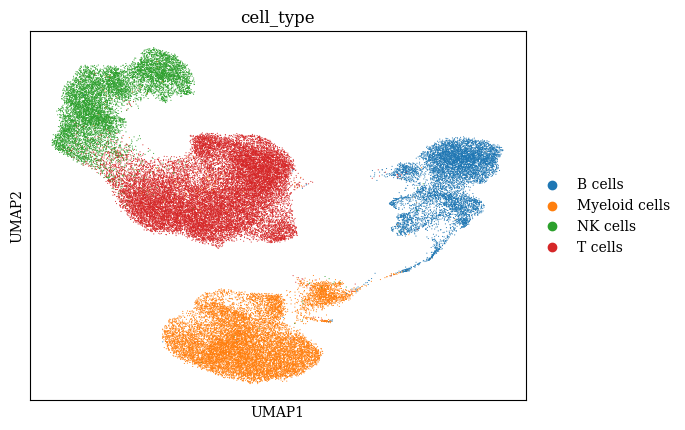

In [7]:
sc.pl.umap(combined, color=["cell_type"], wspace=0.65)

In [25]:
# Open the .link file in read mode
# with open('output/scglue/gene2peak.links', 'r') as file:
#     content = file.read()

# # Print the content of the .link file
# print(content)
df = pd.read_csv('output/scglue/gene2peak.links', sep='\t', header=None)
df['gene'] = df[[0, 1, 2]].astype(str).apply('_'.join, axis=1)
df['peak'] = df[[3,4,5]].astype(str).apply('_'.join, axis=1)


In [34]:
!ls output/scglue

atac-emb.h5ad			       guidance.graphml.gz
atac.h5ad			       JASPAR2022-hg38.bed.gz
consistency_scores.csv		       peaks.bed
ctx_annotation.tsv		       pruned_grn.csv
draft_grn.csv			       rna-emb.h5ad
gencode.v45.annotation.gtf.gz	       rna.h5ad
gene2peak.links			       rna.loom
glue				       supp.genes_vs_tracks.rankings.feather
glue.dill			       tfs.txt
glue.genes_vs_tracks.rankings.feather


In [38]:
df = pd.read_csv("output/scglue/JASPAR2022-hg38.bed.gz", sep='\t')

In [40]:
pruned_grn = pd.read_csv(
        f"output/scglue/pruned_grn.csv", header=None, skiprows=3,
        usecols=[0, 8], names=["TF", "targets"]
    )

In [50]:
pruned_grn.TF.value_counts()

TF
NFKB2     12
GLI1      12
GLIS2     11
IRF7      11
SOX4      10
          ..
THRB       1
FOSL2      1
POU6F2     1
PLAGL1     1
RUNX1      1
Name: count, Length: 160, dtype: int64

In [44]:
from ast import literal_eval

tfs_list = []
target_list = []
weight_list = []
for i, (tf, targets) in pruned_grn.iterrows():
    for target, weight in literal_eval(targets):
        tfs_list.append(tf)
        target_list.append(target)
        weight_list.append(weight)
scglue_grn = pd.DataFrame(np.stack([tfs_list, target_list, weight_list], axis=1), columns=['source','target','weight'])
scglue_grn.source.nunique()

160

## Local runs

In [52]:
if True:
    # methods = par['methods']
    methods = ['scglue']
    for method in methods:
        par['prediction'] = f"{par['models_dir']}/{method}.csv"
        # method arguments 
        method_args=f"--multiomics_rna {par['multiomics_rna']} --prediction {par['prediction']} --num_workers  {par['num_workers']} --resources_dir src/utils"
        # run command
        if method == "pearson_corr":
            command = f"python src/control_methods/pearson/script.py {method_args}"
        elif method == "celloracle":
            command = f"/home/jnourisa/miniconda3/envs/celloracle/bin/python src/methods/multi_omics/celloracle/script.py {method_args}"
        elif method in ["grnboost2", "scenic", "genie3"]:
            command = f"singularity exec ../../images/scenic python src/methods/single_omics/{method}/script.py {method_args}" 
        elif method == 'scglue':
            method_args=f"--multiomics_rna {par['multiomics_rna']} --multiomics_atac {par['multiomics_atac']} --prediction {par['prediction']} --num_workers  {par['num_workers']} --resources_dir src/utils"

            command = f"singularity exec ../../images/scglue python src/methods/multi_omics/{method}/script.py {method_args}"
        elif method == 'ppcor':
            command = f"singularity exec ../../images/ppcor Rscript src/methods/single_omics/{method}/script.R {method_args}"
        else:
            command = f"singularity exec ../../images/{method} python src/methods/single_omics/{method}/script.py {method_args}"
        # sbatch tags
        tag = f"--job-name {method} "
        resources = f" --cpus-per-task {par['num_workers']} --mem {par['mem']} --time {par['time']}" #resources
        tag+=resources
        if method=='scglue':
            tag += f" --partition=gpu --gres=gpu:1"
            
        !sbatch {tag} scripts/sbatch/grn_inference.sh "{command}" 
        # !bash scripts/sbatch/grn_inference.sh "{command}" 

Submitted batch job 7752422


## Baseline models

In [ ]:
if False:
    command = f"--multiomics_rna {par['multiomics_rna']} --models_dir {par['models_dir']}"
    !python src/control_methods/script_all.py {command}

## Seqera

In [14]:
if False: # submit the job
    !bash src/methods/multi_omics/celloracle/run.sh
if False: # get the results
    !aws s3 sync s3://openproblems-data/resources/grn/results/celloracle resources/results/celloracle

download: s3://openproblems-data/resources/grn/results/celloracle/state.yaml to resources/results/celloracle/state.yaml
download: s3://openproblems-data/resources/grn/results/celloracle/trace.txt to resources/results/celloracle/trace.txt
download: s3://openproblems-data/resources/grn/results/celloracle/celloracle.grn_inference_celloracle.prediction.csv to resources/results/celloracle/celloracle.grn_inference_celloracle.prediction.csv
download: s3://openproblems-data/resources/grn/results/celloracle/output/celloracle/base_grn.csv to resources/results/celloracle/output/celloracle/base_grn.csv


In [31]:
if False: # process celloracle
    # - prediction 
    # !mv resources/results/celloracle/celloracle.grn_inference_celloracle.prediction.csv resources/results/celloracle/celloracle.csv 
    !cp resources/results/celloracle/celloracle.csv  {par['models_dir']}/celloracle.csv
    !ls {par['models_dir']}
    
    # -  peak - gene
    # !mkdir resources/grn_models/peak_gene/
    df = pd.read_csv("resources/results/celloracle/output/celloracle/base_grn.csv")[['peak_id','gene_short_name']]
    df.columns = ['peak','target']
    df.to_csv('resources/grn_models/peak_gene/celloracle.csv')

alldonors_default  donor_0_celltype  negative_control.csv  positive_control.csv
celloracle.csv	   donor_0_default   peak_gene		   ppcor.csv
d0_hvg		   granie.csv	     pearson_corr.csv	   scenic.csv
default		   grnboost2.csv     portia.csv		   scglue.csv


# Scores
While we run baseline models using the below commands, for the rest of the models, they must be ran already and their predictions should be given in the relevant folder.

## Calculate scores

In [23]:
# consensus: run this after updating method list
if False:
    model_names = ' '.join(par['methods'])
    command = [
        "python", 
        "src/metrics/regression_2/consensus/script.py", 
        "--models_dir", par['models_dir'], 
        "--models"
    ] + model_names.split()

    # Print command to verify
    subprocess.run(command)

resources/grn-benchmark/perturbation_data.h5ad
['collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'grnboost2', 'scenic', 'scglue', 'celloracle']
Sparsity of resources/grn_models/collectri.csv: 0.9999170526430831
Sparsity of resources/grn_models/negative_control.csv: 0.9998980328944889
Sparsity of resources/grn_models/positive_control.csv: 0.9997840137565959
Sparsity of resources/grn_models/pearson_corr.csv: 0.9997883809984375
Sparsity of resources/grn_models/portia.csv: 0.9999967429274494
Sparsity of resources/grn_models/ppcor.csv: 0.9999794553885274
Sparsity of resources/grn_models/grnboost2.csv: 0.9997985237124277
Sparsity of resources/grn_models/scenic.csv: 0.9997322245751523
Sparsity of resources/grn_models/scglue.csv: 0.9999847772895649
Sparsity of resources/grn_models/celloracle.csv: 0.9997894825282788


In [53]:
# run calculating scores
if False:
    # !bash scripts/sbatch/calculate_scores.sh #includes both reg1 and 2. #inside the script, set the reg_type, read and write dirs, and methods
    !sbatch scripts/sbatch/calculate_scores.sh #includes both reg1 and 2. #inside the script, set the reg_type, read and write dirs, and methods

Submitted batch job 7752425


## Process scores

In [3]:
## full dataset: ridge
df_scores = pd.read_csv(f"resources/scores/scgen_pearson-ridge.csv", index_col=0)
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
collectri,-0.100238,-0.211182,0.489316,0.514896,11
negative_control,-0.044574,-0.045158,0.445727,0.501389,9
positive_control,0.197129,0.578822,0.530848,0.584694,3
pearson_corr,0.273443,0.516343,0.639871,0.549188,2
portia,0.101110,0.365418,0.456203,0.513157,6
ppcor,0.017954,0.159754,0.317136,0.506147,8
grnboost2,0.421936,0.489322,0.825025,0.619527,1
scenic,0.172085,0.228266,0.521234,0.583202,5
granie,0.083298,0.106012,0.323324,0.458506,10
scglue,0.099859,0.279999,0.180594,0.533916,7


In [5]:
## d0_hvgs: ridge
df_scores = pd.read_csv('resources/scores/d0_hvg/scgen_pearson-ridge.csv', index_col=0)
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
collectri,-0.100238,-0.211182,0.489316,0.514896,10
negative_control,-0.039305,-0.041004,0.195831,0.505943,11
positive_control,0.197129,0.578822,0.530848,0.584694,4
pearson_corr,0.269379,0.509297,0.750452,0.542506,3
portia,0.148941,0.227248,0.451256,0.518048,7
ppcor,0.022846,0.094107,0.396680,0.509874,9
genie3,0.372641,0.490357,0.754073,0.576580,2
grnboost2,0.381032,0.459860,0.781852,0.609075,1
scenic,0.147553,0.214694,0.600839,0.574294,6
scglue,0.078309,0.238859,0.448617,0.527076,8


In [7]:

# GB
# df_scores_GB = pd.read_csv("resources/scores/hvg_GB.csv", index_col=0)
# df_all_n = (df_scores_GB-df_scores_GB.min(axis=0))/(df_scores_GB.max(axis=0)-df_scores_GB.min(axis=0))
# df_scores_GB['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
# df_scores_GB.style.background_gradient()

# Format resourcs used

## d0_hvgs

In [18]:
# HVGs: extract resources local jobs
job_ids_dict_hvg = {
    'portia': 7744548,
    'grnboost2': 7742249,
    'scenic': 7742283,
    'genie3': 7742285,
    'ppcor': 7742364,
    'scglue': 7742343,
}
    
df_local = process_trace_local(job_ids_dict_hvg)
df_local

,JobID,JobName,AllocCPUS,Elapsed,State,MaxRSS,MaxVMSize
portia,7744548.bat+,batch,20,0.153611,COMPLETED,5.854904,6.284901
grnboost2,7742249.bat+,batch,20,1.568056,COMPLETED,3.067471,3.563801
scenic,7742283.bat+,batch,20,1.908056,COMPLETED,30.356461,32.573463
genie3,7742285.bat+,batch,20,16.682500,COMPLETED,13.105103,13.563530
ppcor,7742364.bat+,batch,20,0.556667,COMPLETED,3.909119,4.283978
scglue,7742343.bat+,batch,20,4.380278,FAILED,29.917423,35.933720


In [23]:
# sequera 
if False:
    models = ['pearson_causal', 'pearson_corr', 'positive_control']
    base_dir = 'resources/results/d0_hvgs_baseline'
    trace = pd.read_csv(f'{base_dir}/trace.txt', sep='\t')

    trace_baselines = process_trace_seqera(trace)

    models = ['celloracle']
    base_dir = 'resources/results/celloracle_d0_hvgs'
    trace = pd.read_csv(f'{base_dir}/trace.txt', sep='\t')
    trace_models = process_trace(trace)


    trace_seqera = pd.concat([trace_baselines, trace_models], axis=0)
    map_dict = {'peak_rss':'MaxRSS', 'duration':'Elapsed'}

    trace_seqera = trace_seqera[map_dict.keys()]
    trace_seqera.columns = trace_seqera.columns.map(map_dict)
    
    trace_seqera.to_csv('resources/results/trace/trace_seqera_hvg.csv')
    trace_seqera
else:
    trace_seqera = pd.read_csv('resources/results/trace/trace_seqera_hvg.csv', index_col=0)
trace_seqera


,MaxRSS,Elapsed
model,,
pearson_causal,0.9747,0.064167
pearson_corr,0.9751,0.072500
positive_control,4.9000,0.075278
celloracle,14.9000,1.472222


In [24]:
# merge local and cluster dfs 
map_dict = {'peak_rss':'MaxRSS', 'duration':'Elapsed'}

df_local = df_local[map_dict.values()]

df_res = pd.concat([trace_seqera, df_local], axis=0)

df_res.columns = ['Peak memory (GB)', 'Duration (hour)']

df_res.to_csv('resources/results/trace/trace_hvg.csv')

df_res

,Peak memory (GB),Duration (hour)
pearson_causal,0.974700,0.064167
pearson_corr,0.975100,0.072500
positive_control,4.900000,0.075278
celloracle,14.900000,1.472222
portia,5.854904,0.153611
grnboost2,3.067471,1.568056
scenic,30.356461,1.908056
genie3,13.105103,16.682500
ppcor,3.909119,0.556667
scglue,29.917423,4.380278


## Full dataset

In [39]:
# extract resources local jobs
job_ids_dict = {
    'portia': 7751292,
    'grnboost2': 7747906,
    'scenic': 7748219,
    'ppcor': 7748321,
    'scglue': 7751242,
}
   
df_local = process_trace_local(job_ids_dict)
df_local

                  JobID JobName AllocCPUS     Elapsed      State    MaxRSS  \
portia     7748232.bat+   batch        20    02:11:24  COMPLETED  62538604   
grnboost2  7747906.bat+   batch        20    07:30:38  COMPLETED   7320956   
scenic     7748219.bat+   batch        20  1-00:00:31  CANCELLED  34537520   
ppcor      7748321.bat+   batch        20    13:25:33  COMPLETED  66698996   
scglue     7748234.bat+   batch        20    09:23:14  COMPLETED  32842908   

           MaxVMSize  
portia      63369508  
grnboost2    7737228  
scenic      37700816  
ppcor       67251924  
scglue      39884836  


,JobID,JobName,AllocCPUS,Elapsed,State,MaxRSS,MaxVMSize
portia,7748232.bat+,batch,20,2.190000,COMPLETED,59.641460,60.433872
grnboost2,7747906.bat+,batch,20,7.510556,COMPLETED,6.981808,7.378796
scenic,7748219.bat+,batch,20,24.008611,CANCELLED,32.937546,35.954300
ppcor,7748321.bat+,batch,20,13.425833,COMPLETED,63.609119,64.136433
scglue,7748234.bat+,batch,20,9.387222,COMPLETED,31.321438,38.037144


In [52]:
# get seqera 
model = 'celloracle'
base_dir = f'resources/results/{model}'
trace = pd.read_csv(f'{base_dir}/trace.txt', sep='\t')
trace_seqera = process_trace_seqera(trace)
trace_seqera.index = [model]

map_dict = {'peak_rss':'MaxRSS', 'duration':'Elapsed'}

trace_seqera = trace_seqera[map_dict.keys()]
trace_seqera.columns = trace_seqera.columns.map(map_dict)

trace_seqera

/vol/tmp/users/jnourisa/ipykernel_3141337/3691004192.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trace = trace.groupby('model').apply(lambda df: df.sort_values(by='duration', ascending=False).iloc[0])[['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar', 'duration']]


,MaxRSS,Elapsed
celloracle,45.4,3.8075


In [53]:
# merge local and cluster dfs 
map_dict = {'peak_rss':'MaxRSS', 'duration':'Elapsed'}

df_local = df_local[map_dict.values()]

df_res = pd.concat([trace_seqera, df_local], axis=0)

df_res.columns = ['Peak memory (GB)', 'Duration (hour)']

df_res

,Peak memory (GB),Duration (hour)
celloracle,45.400000,3.807500
portia,59.641460,2.190000
grnboost2,6.981808,7.510556
scenic,32.937546,24.008611
ppcor,63.609119,13.425833
scglue,31.321438,9.387222


## Merge scores with resources

In [13]:
df_res = pd.read_csv('resources/results/trace/trace_hvg.csv', index_col=0)
df_scores = pd.read_csv('resources/results/scores/d0_hvg/scgen_pearson-ridge.csv', index_col=0)

In [14]:
# create ranking 
df_scores = df_scores.fillna(0)
df_scores[df_scores < 0]=0
df_scores = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['overall_score'] = df_scores.mean(axis=1)
# df_scores['rank'] = df_scores.mean(axis=1).rank(ascending=False).astype(int)

df_all = pd.concat([df_scores, df_res], axis=1)
df_all = df_all.fillna(0)
df_all.index.name = 'method_name' 
df_all = df_all.reset_index()

df_all 


,method_name,S1,S2,static-theta-0.0,static-theta-0.5,overall_score,Peak memory (GB),Duration (hour)
0,collectri,0.000000,0.000000,0.500809,0.086811,0.146905,0.000000,0.000000
1,negative_control,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,positive_control,0.517356,1.000000,0.571681,0.763590,0.713157,4.900000,0.075278
3,pearson_corr,0.706973,0.879884,0.946418,0.354523,0.721949,0.975100,0.072500
4,portia,0.390888,0.392604,0.435863,0.117372,0.334182,5.854904,0.153611
5,ppcor,0.059957,0.162584,0.342733,0.038118,0.150848,3.909119,0.556667
6,genie3,0.977976,0.847163,0.952597,0.684918,0.865663,13.105103,16.682500
7,grnboost2,1.000000,0.794475,1.000000,1.000000,0.948619,3.067471,1.568056
8,scenic,0.387244,0.370915,0.691114,0.662750,0.528006,30.356461,1.908056
9,scglue,0.205518,0.412663,0.431359,0.204913,0.313613,29.917423,4.380278


## Summary figure

In [40]:

summary_file = "output/summary_d0_hvg.tsv"
summary_figure = "output/summary_d0_hvg_figure.pdf"

df_all['memory_log'] = np.log(df_all['Peak memory (GB)']+1)
df_all['memory_log'] = np.max(df_all['memory_log'])-df_all['memory_log']


df_all["duration_log"] = np.log(df_all['Duration (hour)']+1)
df_all['duration_log'] = np.max(df_all['duration_log'])-df_all['duration_log']

df_all["duration_str"] = df_all['Duration (hour)'].round(1).astype(str)
df_all['memory_str'] =  df_all['Peak memory (GB)'].round(1).astype(str)


df_all.to_csv(summary_file, sep='\t')

!Rscript ../grn_benchmark/src/metrics_figure.R {summary_file} {summary_figure}


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.5.1     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 12 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (12): ...1, S1, S2, static-theta-0.0, static-theta-0.5, overall_score, P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 10 × 7
   id               id_color         name       group geom  palette options     
   <c

# All layers

In [17]:
base_dir = 'resources/scores/d0_hvg'
layers = ['lognorm','pearson', 'seurat_lognorm', 'seurat_pearson', 'scgen_lognorm', 'scgen_pearson']
reg_type = 'ridge'
reg1_metric = 'S1'
reg2_metric = 'static-theta-0.5'
for i, layer in enumerate(layers):
    df = pd.read_csv(f'{base_dir}/{layer}-{reg_type}.csv',index_col=0)
    df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:layer})
    df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:layer})
    
    if i == 0:
        reg1_scores_layers = df_reg1
        reg2_scores_layers = df_reg2
    else:
        reg1_scores_layers = pd.concat([reg1_scores_layers, df_reg1], axis=1)
        reg2_scores_layers = pd.concat([reg2_scores_layers, df_reg2], axis=1)
    
reg1_scores_layers = reg1_scores_layers.T
reg2_scores_layers = reg2_scores_layers.T

reg1_scores_layers.to_csv('../grn_benchmark/results_folder/scores/reg1_scores_layers_hvgs.csv')
reg2_scores_layers.to_csv('../grn_benchmark/results_folder/scores/reg2_scores_layers_hvgs.csv')

reg1_scores_layers.style.background_gradient()


,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,genie3,grnboost2,scenic,scglue,celloracle
lognorm,-0.050548,-0.042234,0.082101,0.046997,0.014856,0.003078,0.073206,0.091619,0.068810,0.027315,0.068165
pearson,-0.095474,-0.041130,0.163470,0.217511,0.113185,0.016686,0.295920,0.299160,0.117241,0.061848,0.171422
seurat_lognorm,-0.052159,-0.041432,0.087152,0.053505,0.017466,0.003723,0.081703,0.105108,0.079217,0.031597,0.078648
seurat_pearson,-0.095343,-0.041747,0.174773,0.219817,0.108111,0.016615,0.293678,0.301832,0.122765,0.064890,0.181489
scgen_lognorm,-0.059849,-0.041816,0.160466,0.094411,0.055487,0.008795,0.162319,0.219727,0.147812,0.060572,0.150424
scgen_pearson,-0.100238,-0.039305,0.197129,0.269379,0.148941,0.022846,0.372641,0.381032,0.147553,0.078309,0.216897


In [21]:
base_dir = 'resources/scores/'
layers = ['lognorm','pearson', 'seurat_lognorm', 'seurat_pearson', 'scgen_lognorm', 'scgen_pearson']
reg_type = 'ridge'
reg1_metric = 'S1'
reg2_metric = 'static-theta-0.5'
for i, layer in enumerate(layers):
    df = pd.read_csv(f'{base_dir}/{layer}-{reg_type}.csv',index_col=0)
    df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:layer})
    df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:layer})
    
    if i == 0:
        reg1_scores_layers = df_reg1
        reg2_scores_layers = df_reg2
    else:
        reg1_scores_layers = pd.concat([reg1_scores_layers, df_reg1], axis=1)
        reg2_scores_layers = pd.concat([reg2_scores_layers, df_reg2], axis=1)
    
reg1_scores_layers = reg1_scores_layers.T
reg2_scores_layers = reg2_scores_layers.T

reg1_scores_layers.to_csv('../grn_benchmark/results_folder/scores/reg1_scores_layers.csv')
reg2_scores_layers.to_csv('../grn_benchmark/results_folder/scores/reg2_scores_layers.csv')

reg1_scores_layers.style.background_gradient()


,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle
lognorm,-0.050548,-0.043757,0.082101,0.062031,0.010746,0.001611,0.118505,0.075060,0.044887,0.035910,0.069066
pearson,-0.095474,-0.043600,0.163470,0.222177,0.082329,0.014658,0.332626,0.130075,0.070551,0.079671,0.167634
seurat_lognorm,-0.052159,-0.044382,0.087152,0.068895,0.011506,0.002132,0.135575,0.080760,0.049640,0.039661,0.080605
seurat_pearson,-0.095343,-0.042833,0.174773,0.226611,0.087287,0.016914,0.339841,0.136727,0.075773,0.079768,0.174873
scgen_lognorm,-0.059849,-0.044936,0.160466,0.117994,0.029785,0.005762,0.263282,0.152383,0.090862,0.071800,0.153270
scgen_pearson,-0.100238,-0.044574,0.197129,0.273443,0.101110,0.017954,0.421936,0.172085,0.083298,0.099859,0.209151


# Robustness analysis

In [54]:
# !python src/robustness_analysis/script_all.py
if True:
    !sbatch scripts/sbatch/robustness_analysis.sh

Submitted batch job 7752429


## Permute

In [2]:
# net 
noise_type = 'net'
base_dir = 'resources/results/robustness_analysis'
degrees = [0, 10, 20, 50, 100]
reg1_metric = 'S1'
reg2_metric = 'static-theta-0.5'
for i, degree in enumerate(degrees):
    df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
    df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
    df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
    
    if i == 0:
        reg1_scores_layers = df_reg1
        reg2_scores_layers = df_reg2
    else:
        reg1_scores_layers = pd.concat([reg1_scores_layers, df_reg1], axis=1)
        reg2_scores_layers = pd.concat([reg2_scores_layers, df_reg2], axis=1)
    
reg1_scores_layers = reg1_scores_layers.T
reg2_scores_layers = reg2_scores_layers.T
reg1_scores_layers.style.background_gradient()


FileNotFoundError: [Errno 2] No such file or directory: 'resources/results/robustness_analysis/net-0-scores.csv'

In [48]:
reg2_scores_layers.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,pearson_causal,portia,ppcor,genie3,grnboost2,scenic,scglue,celloracle
0,0.514896,0.505002,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
10,0.515406,0.505691,0.571882,0.523067,0.555572,0.524393,0.516036,0.570821,0.601759,0.565942,0.530801,0.573236
20,0.511172,0.504663,0.555954,0.526195,0.552449,0.515956,0.515292,0.569976,0.596415,0.561619,0.526821,0.563653
50,0.511803,0.495854,0.552935,0.524744,0.534764,0.516056,0.510711,0.556661,0.581920,0.548328,0.518366,0.542993
100,0.505540,0.503372,0.531005,0.513729,0.523002,0.506760,0.513287,0.504832,0.514585,0.504093,0.506443,0.513158


In [3]:
noise_type = 'sign'
base_dir = 'resources/results/robustness_analysis'
degrees = [0, 10, 20, 50, 100]
reg1_metric = 'S1'
reg2_metric = 'static-theta-0.5'
for i, degree in enumerate(degrees):
    df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
    df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
    df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
    
    if i == 0:
        reg1_scores_layers = df_reg1
        reg2_scores_layers = df_reg2
    else:
        reg1_scores_layers = pd.concat([reg1_scores_layers, df_reg1], axis=1)
        reg2_scores_layers = pd.concat([reg2_scores_layers, df_reg2], axis=1)
    
reg1_scores_layers = reg1_scores_layers.T
reg2_scores_layers = reg2_scores_layers.T
reg1_scores_layers.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,pearson_causal,portia,ppcor,genie3,grnboost2,scenic,scglue,celloracle
0,-0.100238,-0.043795,0.489147,0.238664,0.355256,0.148941,0.022846,0.372641,0.381032,0.147553,0.078309,0.216897
10,-0.107958,-0.042199,0.433246,0.170612,0.297354,0.103448,0.018551,0.309243,0.320476,0.105850,0.051565,0.148519
20,-0.129616,-0.042258,0.383169,0.109502,0.259201,0.064159,-0.001810,0.203046,0.229562,0.067477,0.026945,0.080443
50,-0.154785,-0.040425,-0.091824,-0.000377,-0.188567,-0.090789,-0.013036,-0.114169,-0.122291,-0.025912,-0.010141,-0.135087
100,-0.100238,-0.043795,0.489147,0.238664,0.355256,0.148941,0.022846,0.372641,0.381032,0.147553,0.078309,0.216897


In [4]:
reg2_scores_layers.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,pearson_causal,portia,ppcor,genie3,grnboost2,scenic,scglue,celloracle
0,0.514896,0.505002,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
10,0.514113,0.504708,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
20,0.513857,0.505899,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
50,0.512082,0.506397,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
100,0.508349,0.508202,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147


# repo

In [ ]:
# if par['metacell']:
#     print('metacell')
#     def create_meta_cells(df, n_cells=15):
#         meta_x = []
#         for i in range(0, df.shape[0], n_cells):
#             meta_x.append(df.iloc[i:i+n_cells, :].sum(axis=0).values)
#         df = pd.DataFrame(meta_x, columns=df.columns)
#         return df
            
#     adata_df = pd.DataFrame(multiomics_rna.X.todense(), columns=multiomics_rna.var_names)
#     adata_df['cell_type'] = multiomics_rna.obs['cell_type'].values
#     adata_df['donor_id'] = multiomics_rna.obs['donor_id'].values
#     df = adata_df.groupby(['cell_type','donor_id']).apply(lambda df: create_meta_cells(df))
#     X = df.values
#     var = pd.DataFrame(index=df.columns)
#     obs = df.reset_index()[['cell_type','donor_id']]
#     multiomics_rna = ad.AnnData(X=X, obs=obs, var=var)